In [1]:
%load_ext autoreload
%autoreload complete

from os.path import join
import pickle
import pandas as pd
import numpy as np
from dotenv import dotenv_values
import matplotlib.pyplot as plt
from pyarrow import parquet as pq
import seaborn as sns

import gsvd

sns.set_theme(style="darkgrid")

cfg = dotenv_values()

dat_dir = cfg['DAT_DIR']

alpha = 1

typing_mats_file = join(dat_dir, 'BiAffect_Alex', 'typing_mat_dict.pkl')
svd_mats_file = join(dat_dir, 'BiAffect_Alex', f"svd_mats_alpha{alpha}.pkl")

/home/preclineu/lorkno/Documents/Code/graph-svd/gsvd.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dat_kp: pd.DataFrame = pq.read_table(join(dat_dir, 'BiAffect_Alex', 'dat_kp_alex.parquet')).to_pandas()

dat_kp = dat_kp.loc[dat_kp['phoneType'] == 'iPhone 15'].copy()

# Pandas has trouble computing the min of a date, so convert back to datetime
dat_kp['date'] = pd.to_datetime(dat_kp['keypress_timestamp'].dt.date)
dat_kp['hour'] = dat_kp['keypress_timestamp'].dt.hour
dat_kp['subject'] = 'alex'

dat_kp

,healthCode,phoneInfo,appVersion,session_timestamp,keypress_timestamp,timezone,keypress_type,distanceFromCenter,duration,distanceFromPrevious,sessionNumber,phoneType,IKD,previousKeyType,handedness,date,hour,subject
1347111,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.0.2",version 3.0.10; build 13,2023-12-10 19:24:46.733000+00:00,2023-12-10 19:24:46.732582+00:00,UTC-06:00,alphabet,0.074338,0.083161,NaN,30028,iPhone 15,NaN,None,two-handed,2023-12-10,19,alex
1347112,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.0.2",version 3.0.10; build 13,2023-12-10 19:24:46.733000+00:00,2023-12-10 19:24:46.875797+00:00,UTC-06:00,alphabet,0.158142,0.099893,4.572750,30028,iPhone 15,0.143215,alphabet,two-handed,2023-12-10,19,alex
1347113,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.0.2",version 3.0.10; build 13,2023-12-10 19:24:46.733000+00:00,2023-12-10 19:24:47.009176+00:00,UTC-06:00,alphabet,0.138732,0.083202,4.512893,30028,iPhone 15,0.133379,alphabet,two-handed,2023-12-10,19,alex
1347114,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.0.2",version 3.0.10; build 13,2023-12-10 19:24:46.733000+00:00,2023-12-10 19:24:48.112934+00:00,UTC-06:00,alphabet,0.072470,0.091523,0.536633,30028,iPhone 15,1.103758,alphabet,two-handed,2023-12-10,19,alex
1347115,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.0.2",version 3.0.10; build 13,2023-12-10 19:24:46.733000+00:00,2023-12-10 19:24:48.356969+00:00,UTC-06:00,alphabet,0.190820,0.066566,2.624133,30028,iPhone 15,0.244035,alphabet,two-handed,2023-12-10,19,alex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856890,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.6.1",version 3.0.32; build 36,2024-11-18 22:58:36.700000+00:00,2024-11-18 22:59:14.567072+00:00,UTC-06:00,alphabet,0.099736,0.041607,2.941387,62924,iPhone 15,0.672393,space,two-handed,2024-11-18,22,alex
2856891,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.6.1",version 3.0.32; build 36,2024-11-18 22:58:36.700000+00:00,2024-11-18 22:59:14.732943+00:00,UTC-06:00,alphabet,0.270579,0.058247,0.747416,62924,iPhone 15,0.165871,alphabet,two-handed,2024-11-18,22,alex
2856892,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.6.1",version 3.0.32; build 36,2024-11-18 22:58:36.700000+00:00,2024-11-18 22:59:14.982975+00:00,UTC-06:00,alphabet,0.283403,0.108176,1.356146,62924,iPhone 15,0.250032,alphabet,two-handed,2024-11-18,22,alex
2856893,_08nxJUKt-F_6BUhDzcStMpy,"iPhone15,4; iOS/17.6.1",version 3.0.32; build 36,2024-11-18 22:58:36.700000+00:00,2024-11-18 22:59:15.048082+00:00,UTC-06:00,alphabet,0.191059,0.058260,3.383533,62924,iPhone 15,0.065107,alphabet,two-handed,2024-11-18,22,alex


In [3]:
dat_ses: pd.DataFrame = pq.read_table(join(dat_dir, 'BiAffect_Alex', 'dat_ses_alex.parquet')).to_pandas()

dat_ses = dat_ses.loc[dat_ses['phoneType'] == 'iPhone 15'].copy()

dat_ses['date'] = pd.to_datetime(dat_ses['date'])
dat_ses['hour'] = dat_ses['hour'].astype(int)
dat_ses['subject'] = 'alex'

dat_ses

,sessionNumber,phoneType,medianIKD,percent95IKD,madIKD,handedness,autocorrectRate,backspaceRate,session_timestamp,totalKeyPresses,active,upright,bed,hour,date,timezone,subject
28546,30028,iPhone 15,0.183123,0.332981,0.073716,two-handed,0.000000,0.000000,2023-12-10 19:24:46.733000+00:00,65,True,True,False,19,2023-12-10,UTC-06:00,alex
28547,30029,iPhone 15,0.215565,1.003320,0.022596,NaN,0.000000,0.000000,2023-12-10 19:25:22.162000+00:00,4,False,True,False,19,2023-12-10,UTC-06:00,alex
28548,30030,iPhone 15,0.183500,0.378452,0.061249,NaN,0.000000,0.000000,2023-12-10 19:27:01.280000+00:00,4,False,True,False,19,2023-12-10,UTC-06:00,alex
28549,30031,iPhone 15,0.193112,0.279600,0.014647,two-handed,0.000000,0.000000,2023-12-10 19:28:46.748000+00:00,8,False,True,False,19,2023-12-10,UTC-06:00,alex
28550,30032,iPhone 15,0.233555,0.289387,0.097029,two-handed,0.000000,0.000000,2023-12-10 19:33:04.755000+00:00,8,False,True,False,19,2023-12-10,UTC-06:00,alex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,62920,iPhone 15,0.183078,0.289614,0.071976,two-handed,0.009174,0.027523,2024-11-18 21:10:04.754000+00:00,109,False,True,False,21,2024-11-18,UTC-06:00,alex
59942,62921,iPhone 15,0.215113,0.301019,0.074520,two-handed,0.000000,0.000000,2024-11-18 21:14:41.708000+00:00,37,False,True,False,21,2024-11-18,UTC-06:00,alex
59943,62922,iPhone 15,0.283215,2.227206,0.102497,two-handed,0.000000,0.000000,2024-11-18 21:47:40.898000+00:00,8,False,True,False,21,2024-11-18,UTC-06:00,alex
59944,62923,iPhone 15,0.181924,2.083053,0.047489,two-handed,0.000000,0.000000,2024-11-18 22:24:17.562000+00:00,14,False,True,False,22,2024-11-18,UTC-06:00,alex


In [4]:
typing_matrices, dates = gsvd.get_typing_matrices(dat_kp, dat_ses)

<Axes: xlabel='hour', ylabel='dayNumber'>

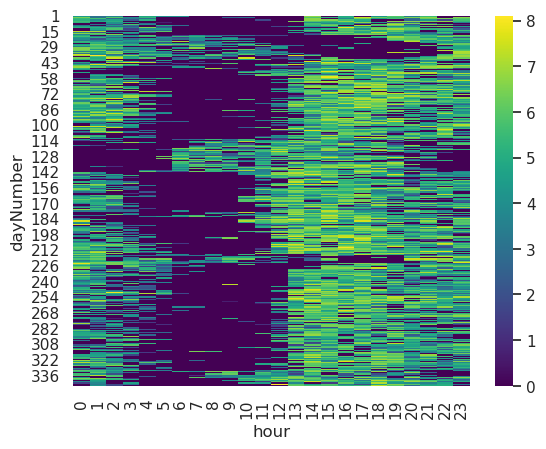

In [5]:
typing_mats = typing_matrices['alex']

sns.heatmap(np.log1p(typing_mats['n_presses']), cmap='viridis')

# Saving/Loading typing mats

In [11]:
typing_mat_dict = {
    "typing_matrices": typing_matrices,
    "dates": dates
}

with open(typing_mats_file, 'wb') as f:
    pickle.dump(typing_mat_dict, f)

In [3]:
with open(typing_mats_file, 'rb') as f:
    typing_mat_dict = pickle.load(f)

typing_matrices: dict[str, dict[str, pd.DataFrame]] = typing_mat_dict["typing_matrices"]
typing_mats = typing_matrices['alex']
dates: pd.DataFrame = typing_mat_dict["dates"]

# Calculating GSVD

In [17]:
svd_mats, split_indices = gsvd.calculate_svd(
    typing_matrices, alpha=alpha, train_ratio=0.05)

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# Saving
with open(svd_mats_file, 'wb') as f:
    pickle.dump(svd_mats, f)

In [6]:
# Loading
with open(svd_mats_file, 'rb') as f:
    svd_mats: dict[str, dict[str, np.ndarray]] = pickle.load(f)

<Axes: >

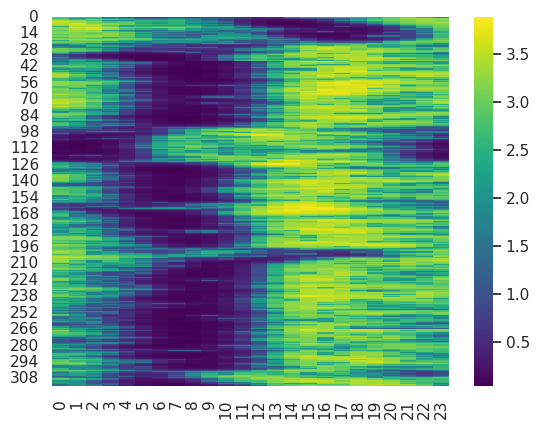

In [11]:
svd_mats = svd_mats['alex']

sns.heatmap(svd_mats['test'], cmap='viridis')

<Axes: ylabel='Count'>

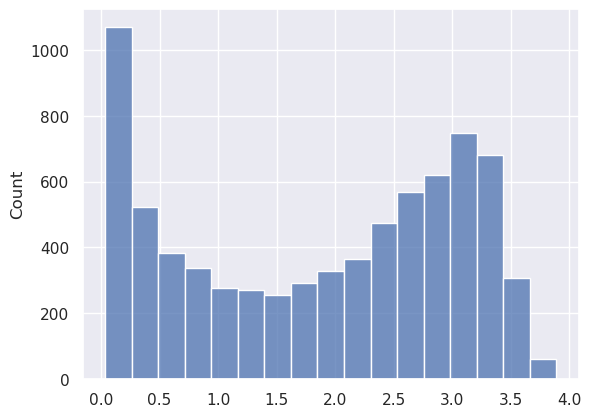

In [26]:
sns.histplot(svd_mats['test'].flatten())

In [22]:
n_train = svd_mats['train'].shape[0]
n_test = svd_mats['test'].shape[0]
labels = ['train'] * n_train + ['test'] * n_test

svd_mat = np.vstack((svd_mats['train'], svd_mats['test']))

# Convert to DataFrame
ikd_index = typing_matrices['alex']['IKD'].index
svd_df = pd.DataFrame(svd_mat, index=ikd_index)

svd_df['label'] = labels

svd_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,label
dayNumber,,,,,,,,,,,,,,,,,,,,,
1,3.351759,2.608602,2.584670,1.777666,2.216050,1.958419,1.682447,0.585939,0.301078,0.319471,...,1.871629,2.722139,2.293481,3.166791,3.343932,3.261496,2.941357,1.744508,1.889330,train
2,3.003861,2.668847,2.867645,2.309946,1.956827,1.078096,0.703155,0.360231,0.298900,0.662495,...,2.578035,3.079970,3.284996,3.305859,3.161627,3.208958,3.053665,2.147346,2.808953,train
3,3.014517,2.940871,2.493303,2.082765,1.701405,0.772080,0.395002,0.213162,0.170699,0.243664,...,2.138492,2.930400,3.258823,2.993605,2.948459,2.821406,3.215025,3.129604,3.196719,train
4,3.038529,2.951970,2.823524,2.006998,1.901500,0.685895,0.286611,0.139877,0.097767,0.114244,...,2.921811,3.160502,2.968401,2.012510,2.036643,2.472628,2.860191,2.645641,2.994861,train
5,3.022780,2.831689,2.840275,1.571406,0.979970,0.469287,0.212283,0.101847,0.064014,0.068094,...,3.048874,3.094620,2.908709,2.063902,2.749617,2.909278,2.837314,2.675768,2.549648,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1.957963,2.064804,1.178437,0.693442,0.328208,0.166631,0.135715,0.217247,0.503690,1.438970,...,3.541673,3.444338,3.111637,3.462492,3.374491,3.224677,2.839334,2.762651,2.676041,test
341,2.397758,1.905522,0.965429,0.620325,0.299432,0.145942,0.104106,0.148690,0.314556,0.699614,...,3.333832,3.546239,3.366364,3.382816,3.349740,3.289571,2.935534,2.557501,2.499147,test
342,1.964954,1.980105,1.122863,1.143323,0.402683,0.159543,0.090185,0.107539,0.220788,0.541334,...,2.385026,3.153256,3.138783,3.405781,3.343467,3.306700,2.731326,2.739585,1.768425,test


In [38]:
svd_date_df = dates.set_index(['dayNumber']) \
    .join(svd_df, how='right') \
    .set_index(['date']) \
    .drop(columns=['subject']) \
    .reset_index()

svd_df_long = pd.melt(svd_date_df, id_vars=['date', 'label'], var_name='hour') \
    .sort_values(['date', 'hour']) \
    .reset_index(drop=True)

svd_df_long['date'] = svd_df_long['date'].dt.date

svd_df_long

,date,label,hour,value
0,2023-12-11,train,0,3.351759
1,2023-12-11,train,1,2.608602
2,2023-12-11,train,2,2.584670
3,2023-12-11,train,3,1.777666
4,2023-12-11,train,4,2.216050
...,...,...,...,...
7939,2024-11-18,test,19,3.436004
7940,2024-11-18,test,20,3.117246
7941,2024-11-18,test,21,3.143272
7942,2024-11-18,test,22,2.886191


In [39]:
svd_df_long.to_parquet(join(dat_dir, 'BiAffect_Alex', 'svd_long.parquet'))